In [1]:
from joblib import load
import sys
from Sparse_vector.sparse_vector import SparseVector
from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve

In [2]:
import urllib.request

url = "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes"
filename = "hg38.chrom.sizes"

urllib.request.urlretrieve(url, filename)
chrom_sizes_file = "hg38.chrom.sizes"

def get_chrom_sizes():
    chrom_sizes = {}
    with open(chrom_sizes_file) as f:
        for line in f:
            name, size = line.strip().split("\t")
            chrom_sizes[name] = int(size)
    return chrom_sizes
  
chr_size = get_chrom_sizes()

In [3]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
features = [i[:-4] for i in os.listdir('omicDC_results_Bone/')]
groups = ['Histone', 'TFs']
feature_names = [i for i in features if (i.split('_')[0] in groups)]
DNA_features = {feture: load(f'omicDC_results_Bone/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/144 [00:00<?, ?it/s]

In [4]:
from collections import defaultdict

result_dict = defaultdict(set)

with open("bone.bed", "r") as bed_file:
    for line in bed_file:
        chrom, start, end = line.strip().split("\t")[:3]
        start, end = int(start), int(end)
        result_dict[chrom].update(set(range(start, end+1)))


In [5]:
win_in = []
win_out = []
width = 50000
ws = [-20*width, -10*width, -5*width, 5*width, 10*width, 20*width]

for chrm in tqdm(chrom_names):
    first_time = True
    for pos in result_dict[chrm]:  
        win_in.append([chrm, max(pos - width//2, 0), min(pos + width//2, chr_size[chrm])])
        for w in ws:
            if w < 0:
                w = abs(w)
                pos -= w
            else:
                pos += w
            interval = [min(max(pos - width//2, 0), chr_size[chrm]), max(0, min(pos + width//2, chr_size[chrm]))]
            is_in = False
            for i in range(interval[0], interval[1]+1):
                if interval[0] + i in result_dict[chrm]:
                    is_in = True
                    break
            if not is_in and interval[0] != interval[1]:
                win_out.append([chrm, interval[0], interval[1]])

  0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
win_in[:10]

[['chr1', 42701400, 42751400],
 ['chr1', 165571417, 165621417],
 ['chr1', 234992474, 235042474],
 ['chr1', 165571419, 165621419],
 ['chr1', 143261532, 143311532],
 ['chr1', 162159450, 162209450],
 ['chr1', 45743966, 45793966],
 ['chr1', 37942110, 37992110],
 ['chr1', 174616671, 174666671],
 ['chr1', 120108385, 120158385]]

In [7]:
win_out[:10]

[['chr1', 41701400, 41751400],
 ['chr1', 41201400, 41251400],
 ['chr1', 40951400, 41001400],
 ['chr1', 41201400, 41251400],
 ['chr1', 41701400, 41751400],
 ['chr1', 42701400, 42751400],
 ['chr1', 164571417, 164621417],
 ['chr1', 164071417, 164121417],
 ['chr1', 163821417, 163871417],
 ['chr1', 164071417, 164121417]]

In [8]:
print(len(win_in), len(win_out))

2424 14315


In [9]:
ints_in1 = np.array(win_in)
ints_out1 = np.array(win_out)[np.random.choice(range(len(win_out)), size=len(win_in) * 2, replace=False)]


In [10]:
print(len(ints_in1), len(ints_out1))

2424 4848


In [11]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

equalized1 = [[inter[0], int(inter[1]), int(inter[2]), 1] for inter in ints_in1]
equalized0 = [[inter[0], int(inter[1]), int(inter[2]), 0] for inter in ints_out1]
equalized = np.vstack((equalized1, equalized0))

np.random.shuffle(equalized)
equalized[0:10]

array([['chrX', '124041004', '124091004', '1'],
       ['chr10', '76258903', '76308903', '0'],
       ['chr8', '61019350', '61069350', '1'],
       ['chr1', '37493116', '37543116', '1'],
       ['chr11', '127264394', '127314394', '0'],
       ['chr22', '28016055', '28066055', '0'],
       ['chr12', '17570823', '17620823', '0'],
       ['chr3', '116508390', '116558390', '1'],
       ['chr8', '115518958', '115568958', '0'],
       ['chr20', '55114169', '55164169', '1']], dtype='<U21')

In [12]:
import numpy as np
import torch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

X = []
y = []

pbar = tqdm(total=len(equalized))

for idx in range(len(equalized)):
    pbar.update(1)
    inter = equalized[idx]
    chrom = inter[0]
    begin = int(inter[1])
    end = int(inter[2])
    target = int(inter[3])
    feature_matr = []
    for feature in feature_names:
        source = DNA_features[feature]
        feature_matr.append(source[chrom][begin:end].mean())

    if len(feature_matr) > 0:
        new_row = np.hstack(np.array(feature_matr).T).astype(np.float32) 
        X.append(new_row)
        y.append(target)
    else:
        continue 

pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 7272/7272 [02:21<00:00, 51.53it/s]


In [13]:

X = np.array(X)


scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)


X = torch.tensor(X_normalized, dtype=torch.float)
y = torch.tensor(y, dtype=torch.int64)

In [14]:
X = np.array(X)
X

array([[-0.33514696, -0.08296457, -0.09032363, ..., -0.28980133,
        -0.0574721 , -0.29045078],
       [-0.34374797,  1.0491    ,  0.38136685, ..., -0.250708  ,
        -0.0574721 , -0.29045078],
       [-0.42605662, -0.08296457, -0.09032363, ..., -0.21869174,
        -0.0574721 , -0.29045078],
       ...,
       [-0.42605662, -0.08296457, -0.09032363, ..., -0.14938723,
        -0.0574721 , -0.29045078],
       [-0.42605662, -0.08296457, -0.09032363, ..., -0.18932936,
        -0.0574721 , -0.29045078],
       [-0.23139966,  3.1604557 , -0.09032363, ..., -0.1767646 ,
        -0.0574721 , -0.29045078]], dtype=float32)

In [15]:
X.shape

(7272, 144)

In [16]:
y

tensor([1, 0, 1,  ..., 0, 0, 1])

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование y_train и y_test в массивы NumPy
y_train = np.array(y_train)
y_test = np.array(y_test)

# Нормализация входных данных
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC score: {:.4f}".format(roc_auc))


2023-05-15 23:29:17.613000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 23:29:18.439254: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/10
182/182 [==============================] - 3s 10ms/step - loss: 0.6372 - accuracy: 0.6670 - val_loss: 0.6291 - val_accuracy: 0.6632
Epoch 2/10
182/182 [==============================] - 2s 10ms/step - loss: 0.6289 - accuracy: 0.6773 - val_loss: 0.6243 - val_accuracy: 0.6749
Epoch 3/10
182/182 [==============================] - 2s 11ms/step - loss: 0.6276 - accuracy: 0.6811 - val_loss: 0.6222 - val_accuracy: 0.6749
Epoch 4/10
182/182 [==============================] - 2s 10ms/step - loss: 0.6255 - accuracy: 0.6821 - val_loss: 0.6224 - val_accuracy: 0.6742
Epoch 5/10
182/182 [==============================] - 2s 9ms/step - loss: 0.6254 - accuracy: 0.6823 - val_loss: 0.6251 - val_accuracy: 0.6749
Epoch 6/10
182/182 [==============================] - 2s 10ms/step - loss: 0.6309 - accuracy: 0.6758 - val_loss: 0.6266 - val_accuracy: 0.6756
Epoch 7/10
182/182 [==============================] - 2s 10ms/step - loss: 0.6255 - accuracy: 0.6811 - val_loss: 0.6270 - val_accuracy: 0.6756


In [21]:
X

array([[-0.33514696, -0.08296457, -0.09032363, ..., -0.28980133,
        -0.0574721 , -0.29045078],
       [-0.34374797,  1.0491    ,  0.38136685, ..., -0.250708  ,
        -0.0574721 , -0.29045078],
       [-0.42605662, -0.08296457, -0.09032363, ..., -0.21869174,
        -0.0574721 , -0.29045078],
       ...,
       [-0.42605662, -0.08296457, -0.09032363, ..., -0.14938723,
        -0.0574721 , -0.29045078],
       [-0.42605662, -0.08296457, -0.09032363, ..., -0.18932936,
        -0.0574721 , -0.29045078],
       [-0.23139966,  3.1604557 , -0.09032363, ..., -0.1767646 ,
        -0.0574721 , -0.29045078]], dtype=float32)

In [22]:
y

tensor([1, 0, 1,  ..., 0, 0, 1])

In [23]:
from copy import deepcopy
X_copy = deepcopy(X)
y_copy = deepcopy(y)

In [24]:
X = X_copy
y = y_copy

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []


for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        if np.array(true_labels).std() == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_1510/3757297636.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_1510/3757297636.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6178, Train F1-score: 0.7778, Train ROC-AUC: 0.8750, Train PR-AUC: 0.2500, Test Loss: 0.6109, Test F1-score: 0.5992, Test ROC-AUC: 0.6454, Test PR-AUC: 0.4913
Epoch [2/20], Train Loss: 0.5909, Train F1-score: 0.4762, Train ROC-AUC: 0.3333, Train PR-AUC: 0.2472, Test Loss: 0.6012, Test F1-score: 0.6495, Test ROC-AUC: 0.6611, Test PR-AUC: 0.4967
Epoch [3/20], Train Loss: 0.5713, Train F1-score: 0.6667, Train ROC-AUC: 0.7500, Train PR-AUC: 0.7714, Test Loss: 0.6172, Test F1-score: 0.6518, Test ROC-AUC: 0.6445, Test PR-AUC: 0.4985
Epoch [4/20], Train Loss: 0.5502, Train F1-score: 0.6462, Train ROC-AUC: 0.6111, Train PR-AUC: 0.5687, Test Loss: 0.6083, Test F1-score: 0.6742, Test ROC-AUC: 0.6793, Test PR-AUC: 0.5024
Epoch [5/20], Train Loss: 0.5316, Train F1-score: 0.5333, Train ROC-AUC: 0.6111, Train PR-AUC: 0.3879, Test Loss: 0.6219, Test F1-score: 0.6678, Test ROC-AUC: 0.6754, Test PR-AUC: 0.5104
Epoch [6/20], Train Loss: 0.5153, Train F1-score: 0.7778, Train R

/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [9/20], Train Loss: 0.4741, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6984, Test F1-score: 0.6974, Test ROC-AUC: 0.6979, Test PR-AUC: 0.5226


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [10/20], Train Loss: 0.4612, Train F1-score: 0.9412, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.7217, Test F1-score: 0.6922, Test ROC-AUC: 0.7018, Test PR-AUC: 0.5204
Epoch [11/20], Train Loss: 0.4530, Train F1-score: 0.7778, Train ROC-AUC: 0.9286, Train PR-AUC: 0.7917, Test Loss: 0.7625, Test F1-score: 0.6925, Test ROC-AUC: 0.7013, Test PR-AUC: 0.5206
Epoch [12/20], Train Loss: 0.4419, Train F1-score: 0.7593, Train ROC-AUC: 0.7000, Train PR-AUC: 0.7464, Test Loss: 0.7574, Test F1-score: 0.6933, Test ROC-AUC: 0.7053, Test PR-AUC: 0.5225
Epoch [13/20], Train Loss: 0.4362, Train F1-score: 0.7381, Train ROC-AUC: 0.7778, Train PR-AUC: 0.6556, Test Loss: 0.7905, Test F1-score: 0.6987, Test ROC-AUC: 0.7027, Test PR-AUC: 0.5219
Epoch [14/20], Train Loss: 0.4243, Train F1-score: 0.8860, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.8091, Test F1-score: 0.6922, Test ROC-AUC: 0.6976, Test PR-AUC: 0.5169


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [15/20], Train Loss: 0.4164, Train F1-score: 0.9412, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.8594, Test F1-score: 0.6904, Test ROC-AUC: 0.6970, Test PR-AUC: 0.5116
Epoch [16/20], Train Loss: 0.4123, Train F1-score: 0.7778, Train ROC-AUC: 0.7857, Train PR-AUC: 0.6625, Test Loss: 0.9051, Test F1-score: 0.6988, Test ROC-AUC: 0.7066, Test PR-AUC: 0.5164
Epoch [17/20], Train Loss: 0.4065, Train F1-score: 0.6806, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.9081, Test F1-score: 0.6952, Test ROC-AUC: 0.7034, Test PR-AUC: 0.5106
Epoch [18/20], Train Loss: 0.3974, Train F1-score: 0.6806, Train ROC-AUC: 0.7857, Train PR-AUC: 0.6625, Test Loss: 0.9609, Test F1-score: 0.6983, Test ROC-AUC: 0.7053, Test PR-AUC: 0.5040
Epoch [19/20], Train Loss: 0.3939, Train F1-score: 0.6806, Train ROC-AUC: 0.7857, Train PR-AUC: 0.6625, Test Loss: 0.9570, Test F1-score: 0.6944, Test ROC-AUC: 0.6997, Test PR-AUC: 0.5009
Epoch [20/20], Train Loss: 0.3877, Train F1-score: 0.8741, T

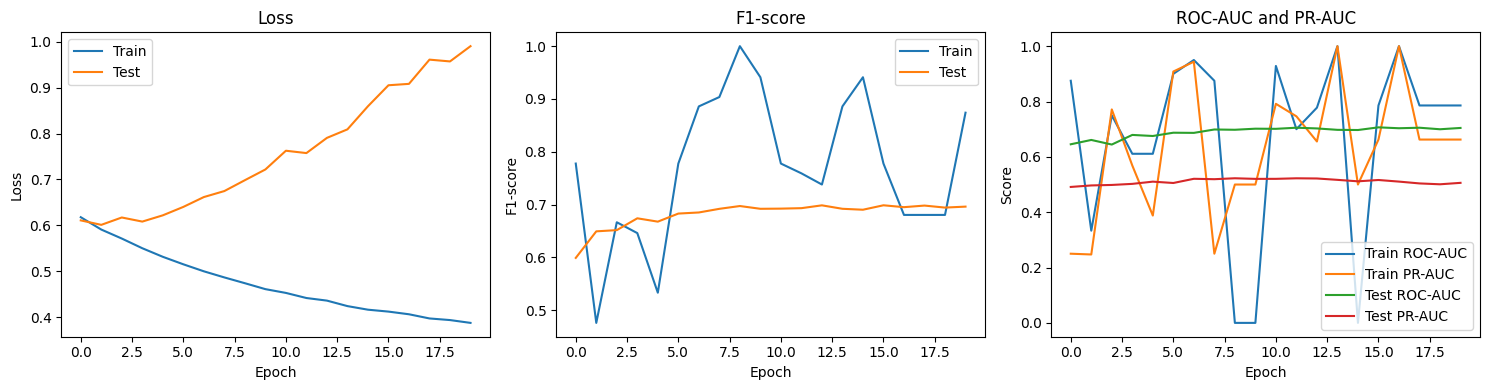

In [27]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

# Эта ячейка работает лучше всего

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes) 
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)  
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out.squeeze(1)


input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 1 
num_epochs = 20
batch_size = 64
learning_rate = 0.0001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)  
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)


model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = torch.sigmoid(outputs).cpu().detach().numpy()
        predicted_probs.extend(probs)
        preds = (probs > 0.5).astype(int)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds)

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = torch.sigmoid(test_outputs).cpu().detach().numpy()
        test_predicted_probs = probs
        test_preds = (probs > 0.5).astype(int)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds, average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)



/tmp/ipykernel_1510/1626131257.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)  # Изменение: тип данных float
/tmp/ipykernel_1510/1626131257.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)  # Изменение: тип данных float


Epoch [1/20], Train Loss: 0.6808, Train F1-score: 0.6047, Train ROC-AUC: 0.5509, Train PR-AUC: 0.4050, Test Loss: 0.6666, Test F1-score: 0.6243, Test ROC-AUC: 0.5981, Test PR-AUC: 0.4424
Epoch [2/20], Train Loss: 0.6518, Train F1-score: 0.6192, Train ROC-AUC: 0.5754, Train PR-AUC: 0.4303, Test Loss: 0.6354, Test F1-score: 0.6336, Test ROC-AUC: 0.6020, Test PR-AUC: 0.4467
Epoch [3/20], Train Loss: 0.6301, Train F1-score: 0.6194, Train ROC-AUC: 0.5884, Train PR-AUC: 0.4369, Test Loss: 0.6237, Test F1-score: 0.6310, Test ROC-AUC: 0.6078, Test PR-AUC: 0.4524
Epoch [4/20], Train Loss: 0.6229, Train F1-score: 0.6216, Train ROC-AUC: 0.5960, Train PR-AUC: 0.4496, Test Loss: 0.6194, Test F1-score: 0.6218, Test ROC-AUC: 0.6153, Test PR-AUC: 0.4573
Epoch [5/20], Train Loss: 0.6180, Train F1-score: 0.6121, Train ROC-AUC: 0.6066, Train PR-AUC: 0.4564, Test Loss: 0.6165, Test F1-score: 0.6162, Test ROC-AUC: 0.6201, Test PR-AUC: 0.4659
Epoch [6/20], Train Loss: 0.6156, Train F1-score: 0.6046, Train R

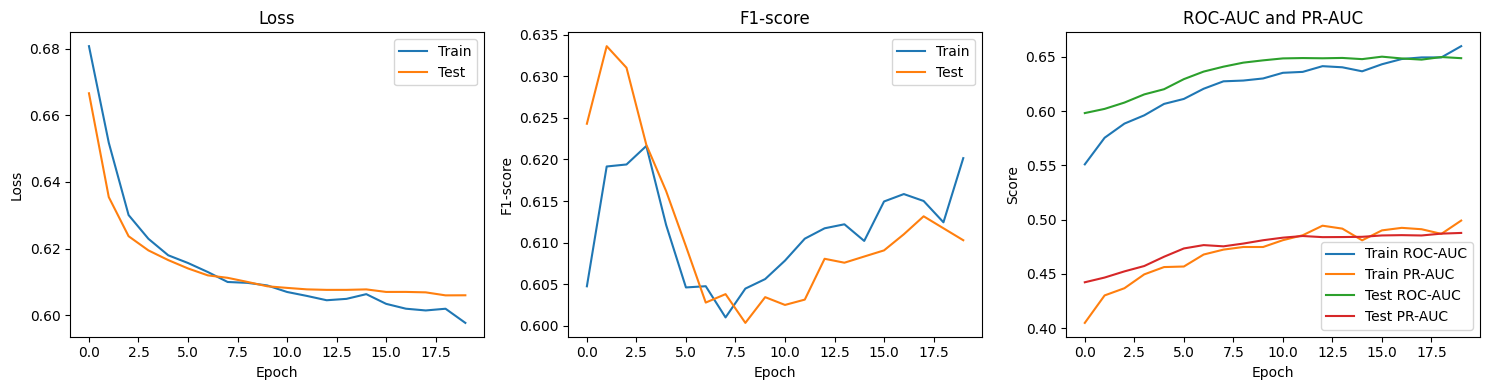

In [29]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import accuracy_score
def permutation_importance(model, X_test, y_test, metric, feature_names):
    base_score = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test)) > 0.5).cpu().numpy().astype(int))
    feature_importances = []
    X_test_permuted = X_test.clone()
    for i in range(X_test.shape[-1]):
        np.random.shuffle(X_test_permuted[:, :, i].cpu().numpy())
        score_permuted = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test_permuted)) > 0.5).cpu().numpy().astype(int))
        feature_importances.append(base_score - score_permuted)
        X_test_permuted = X_test.clone() 
    
    feature_importance_dict = {name: importance for name, importance in zip(feature_names, feature_importances)}
    sorted_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_importances

feat_names = feature_names

sorted_feature_importances = permutation_importance(model, X_test, y_test, accuracy_score, feat_names)

for name, imp in sorted_feature_importances:
    print(f'Feature {name} importance: {imp}')


Feature TFs_NR3C1 importance: 0.0027491408934707806
Feature TFs_SUMO2 importance: 0.0027491408934707806
Feature TFs_ESR2 importance: 0.0020618556701030855
Feature TFs_NELFE importance: 0.0020618556701030855
Feature TFs_STAG2 importance: 0.0020618556701030855
Feature TFs_TCF4 importance: 0.0020618556701030855
Feature TFs_WDR5 importance: 0.0020618556701030855
Feature Histone_H4K20me1 importance: 0.0013745704467353903
Feature Histone_H3K56ac importance: 0.0013745704467353903
Feature TFs_ESR1 importance: 0.0013745704467353903
Feature TFs_EZH2 importance: 0.0013745704467353903
Feature TFs_GABPA importance: 0.0013745704467353903
Feature TFs_GTF2F1 importance: 0.0013745704467353903
Feature TFs_HNF1B importance: 0.0013745704467353903
Feature TFs_MYC importance: 0.0013745704467353903
Feature TFs_RAD21 importance: 0.0013745704467353903
Feature TFs_SFPQ importance: 0.0013745704467353903
Feature TFs_STAG1 importance: 0.0013745704467353903
Feature TFs_TRIM28 importance: 0.0013745704467353903
Featu

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


import torch.nn.functional as F

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out


input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []


for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_1510/528756788.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_1510/528756788.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6233, Train F1-score: 0.5333, Train ROC-AUC: 0.8333, Train PR-AUC: 0.8167, Test Loss: 0.6138, Test F1-score: 0.6143, Test ROC-AUC: 0.6320, Test PR-AUC: 0.4721
Epoch [2/20], Train Loss: 0.6143, Train F1-score: 0.4815, Train ROC-AUC: 0.7000, Train PR-AUC: 0.7231, Test Loss: 0.6095, Test F1-score: 0.6145, Test ROC-AUC: 0.6490, Test PR-AUC: 0.4731
Epoch [3/20], Train Loss: 0.6036, Train F1-score: 0.2778, Train ROC-AUC: 0.2500, Train PR-AUC: 0.3102, Test Loss: 0.6015, Test F1-score: 0.6408, Test ROC-AUC: 0.6612, Test PR-AUC: 0.4937
Epoch [4/20], Train Loss: 0.6001, Train F1-score: 0.5185, Train ROC-AUC: 0.7500, Train PR-AUC: 0.6917, Test Loss: 0.6103, Test F1-score: 0.6422, Test ROC-AUC: 0.6549, Test PR-AUC: 0.4940
Epoch [5/20], Train Loss: 0.6016, Train F1-score: 0.5556, Train ROC-AUC: 0.4286, Train PR-AUC: 0.1833, Test Loss: 0.5979, Test F1-score: 0.6378, Test ROC-AUC: 0.6600, Test PR-AUC: 0.5040
Epoch [6/20], Train Loss: 0.5964, Train F1-score: 0.8366, Train R

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out


input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs[:, 1] > 0.5).long()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        softmax = nn.Softmax(dim=1)
        probs = softmax(outputs)
        predicted_probs.extend(probs[:, 1].detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)


    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_probs = softmax(test_outputs)
        test_preds = (test_probs[:, 1] > 0.5).long()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')


        softmax = nn.Softmax(dim=1)
        test_probs = softmax(test_outputs)
        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_1510/1862407589.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_1510/1862407589.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6243, Train F1-score: 0.6119, Train ROC-AUC: 0.5979, Train PR-AUC: 0.4384, Test Loss: 0.6112, Test F1-score: 0.6151, Test ROC-AUC: 0.6473, Test PR-AUC: 0.4838
Epoch [2/20], Train Loss: 0.5973, Train F1-score: 0.6546, Train ROC-AUC: 0.6546, Train PR-AUC: 0.5133, Test Loss: 0.6163, Test F1-score: 0.6487, Test ROC-AUC: 0.6394, Test PR-AUC: 0.4958
Epoch [3/20], Train Loss: 0.5843, Train F1-score: 0.6903, Train ROC-AUC: 0.6707, Train PR-AUC: 0.5447, Test Loss: 0.6008, Test F1-score: 0.6690, Test ROC-AUC: 0.6635, Test PR-AUC: 0.5207
Epoch [4/20], Train Loss: 0.5739, Train F1-score: 0.7044, Train ROC-AUC: 0.6866, Train PR-AUC: 0.5604, Test Loss: 0.6022, Test F1-score: 0.6577, Test ROC-AUC: 0.6625, Test PR-AUC: 0.5180
Epoch [5/20], Train Loss: 0.5636, Train F1-score: 0.7222, Train ROC-AUC: 0.6995, Train PR-AUC: 0.5753, Test Loss: 0.6010, Test F1-score: 0.6705, Test ROC-AUC: 0.6526, Test PR-AUC: 0.5183
Epoch [6/20], Train Loss: 0.5562, Train F1-score: 0.7304, Train R

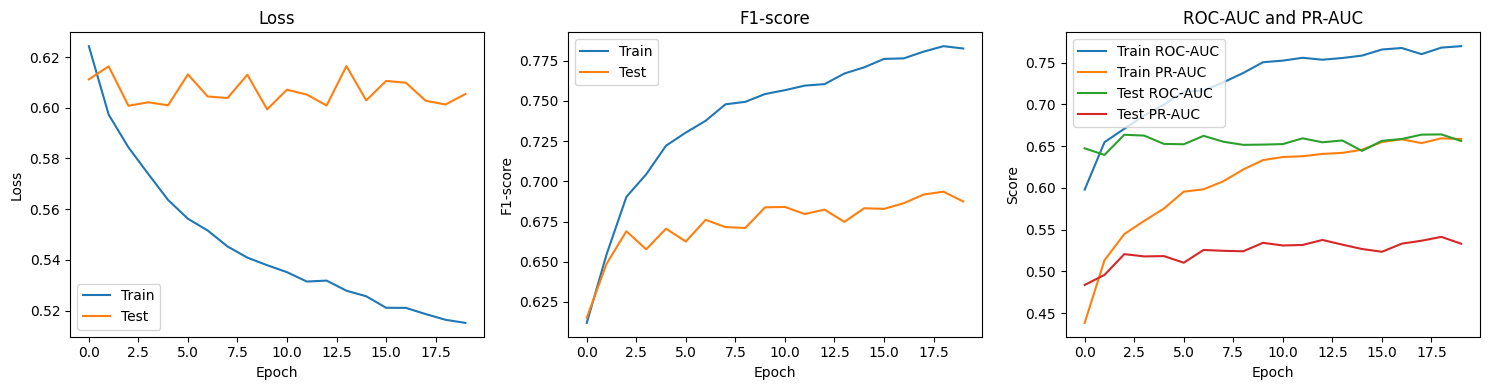

In [33]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out.squeeze()


input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_epochs = 30
batch_size = 64
learning_rate = 0.001


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)


dropout_prob = 0.5
train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs > 0.5).float()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        predicted_probs.extend(outputs.detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

 
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_preds = (test_outputs > 0.5).float()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')


        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_1510/792856689.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)
/tmp/ipykernel_1510/792856689.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)


Epoch [1/30], Train Loss: 0.6231, Train F1-score: 0.5942, Train ROC-AUC: 0.5951, Train PR-AUC: 0.4384, Test Loss: 0.6070, Test F1-score: 0.6069, Test ROC-AUC: 0.6487, Test PR-AUC: 0.4917
Epoch [2/30], Train Loss: 0.6021, Train F1-score: 0.6192, Train ROC-AUC: 0.6483, Train PR-AUC: 0.4928, Test Loss: 0.5996, Test F1-score: 0.6186, Test ROC-AUC: 0.6595, Test PR-AUC: 0.5074
Epoch [3/30], Train Loss: 0.5860, Train F1-score: 0.6557, Train ROC-AUC: 0.6761, Train PR-AUC: 0.5290, Test Loss: 0.6027, Test F1-score: 0.6508, Test ROC-AUC: 0.6571, Test PR-AUC: 0.5096
Epoch [4/30], Train Loss: 0.5775, Train F1-score: 0.6717, Train ROC-AUC: 0.6904, Train PR-AUC: 0.5396, Test Loss: 0.5973, Test F1-score: 0.6694, Test ROC-AUC: 0.6666, Test PR-AUC: 0.5063
Epoch [5/30], Train Loss: 0.5683, Train F1-score: 0.6887, Train ROC-AUC: 0.7072, Train PR-AUC: 0.5569, Test Loss: 0.5989, Test F1-score: 0.6691, Test ROC-AUC: 0.6719, Test PR-AUC: 0.5093
Epoch [6/30], Train Loss: 0.5529, Train F1-score: 0.6974, Train R

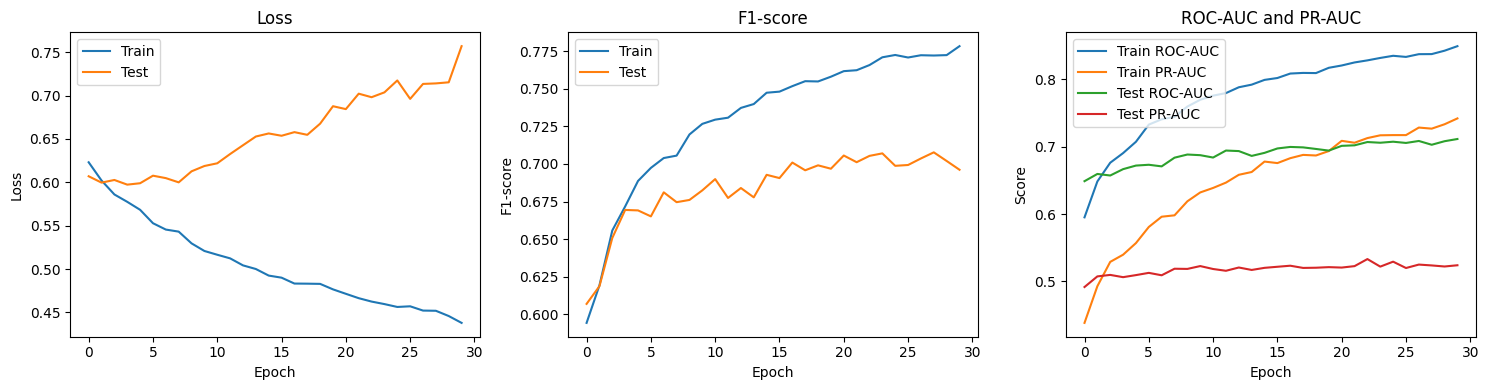

In [35]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve
from torch.utils.data import DataLoader, TensorDataset


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


input_size = X.shape[1]
hidden_size = 256
num_layers = 3
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)



train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(tqdm(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)


    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = nn.functional.softmax(test_outputs, dim=1)
        test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
        _, test_preds = torch.max(test_outputs, 1)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)

/tmp/ipykernel_1510/140274637.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_1510/140274637.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)
100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 58.77it/s]


Epoch [1/20], Train Loss: 0.6211, Train F1-score: 0.5972, Train ROC-AUC: 0.6048, Train PR-AUC: 0.4465, Test Loss: 0.6126, Test F1-score: 0.5904, Test ROC-AUC: 0.6492, Test PR-AUC: 0.4891


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 57.00it/s]


Epoch [2/20], Train Loss: 0.6039, Train F1-score: 0.6271, Train ROC-AUC: 0.6444, Train PR-AUC: 0.4839, Test Loss: 0.6107, Test F1-score: 0.6433, Test ROC-AUC: 0.6522, Test PR-AUC: 0.4929


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 56.97it/s]


Epoch [3/20], Train Loss: 0.5893, Train F1-score: 0.6618, Train ROC-AUC: 0.6735, Train PR-AUC: 0.5216, Test Loss: 0.6013, Test F1-score: 0.6560, Test ROC-AUC: 0.6685, Test PR-AUC: 0.5109


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 57.32it/s]


Epoch [4/20], Train Loss: 0.5761, Train F1-score: 0.6759, Train ROC-AUC: 0.6947, Train PR-AUC: 0.5417, Test Loss: 0.5985, Test F1-score: 0.6596, Test ROC-AUC: 0.6713, Test PR-AUC: 0.5162


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 56.91it/s]


Epoch [5/20], Train Loss: 0.5628, Train F1-score: 0.6880, Train ROC-AUC: 0.7144, Train PR-AUC: 0.5586, Test Loss: 0.6082, Test F1-score: 0.6614, Test ROC-AUC: 0.6686, Test PR-AUC: 0.5070


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 57.09it/s]


Epoch [6/20], Train Loss: 0.5518, Train F1-score: 0.6913, Train ROC-AUC: 0.7316, Train PR-AUC: 0.5826, Test Loss: 0.5936, Test F1-score: 0.6707, Test ROC-AUC: 0.6988, Test PR-AUC: 0.5310


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 57.14it/s]


Epoch [7/20], Train Loss: 0.5419, Train F1-score: 0.6994, Train ROC-AUC: 0.7423, Train PR-AUC: 0.5958, Test Loss: 0.6687, Test F1-score: 0.6727, Test ROC-AUC: 0.6891, Test PR-AUC: 0.5201


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 56.94it/s]


Epoch [8/20], Train Loss: 0.5303, Train F1-score: 0.7087, Train ROC-AUC: 0.7581, Train PR-AUC: 0.6105, Test Loss: 0.6595, Test F1-score: 0.6887, Test ROC-AUC: 0.6771, Test PR-AUC: 0.5015


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 57.00it/s]


Epoch [9/20], Train Loss: 0.5293, Train F1-score: 0.7147, Train ROC-AUC: 0.7537, Train PR-AUC: 0.6151, Test Loss: 0.6253, Test F1-score: 0.6691, Test ROC-AUC: 0.6884, Test PR-AUC: 0.5014


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 56.83it/s]


Epoch [10/20], Train Loss: 0.5196, Train F1-score: 0.7255, Train ROC-AUC: 0.7664, Train PR-AUC: 0.6282, Test Loss: 0.6252, Test F1-score: 0.6800, Test ROC-AUC: 0.6911, Test PR-AUC: 0.5020


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 57.04it/s]


Epoch [11/20], Train Loss: 0.5049, Train F1-score: 0.7322, Train ROC-AUC: 0.7855, Train PR-AUC: 0.6512, Test Loss: 0.6327, Test F1-score: 0.6783, Test ROC-AUC: 0.6907, Test PR-AUC: 0.5124


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 58.15it/s]


Epoch [12/20], Train Loss: 0.5017, Train F1-score: 0.7319, Train ROC-AUC: 0.7840, Train PR-AUC: 0.6562, Test Loss: 0.6616, Test F1-score: 0.6782, Test ROC-AUC: 0.6859, Test PR-AUC: 0.5042


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 56.99it/s]


Epoch [13/20], Train Loss: 0.4957, Train F1-score: 0.7411, Train ROC-AUC: 0.7919, Train PR-AUC: 0.6644, Test Loss: 0.6835, Test F1-score: 0.6725, Test ROC-AUC: 0.6818, Test PR-AUC: 0.5044


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 57.45it/s]


Epoch [14/20], Train Loss: 0.4912, Train F1-score: 0.7442, Train ROC-AUC: 0.7984, Train PR-AUC: 0.6725, Test Loss: 0.6888, Test F1-score: 0.6872, Test ROC-AUC: 0.6905, Test PR-AUC: 0.5026


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 56.67it/s]


Epoch [15/20], Train Loss: 0.4849, Train F1-score: 0.7475, Train ROC-AUC: 0.8038, Train PR-AUC: 0.6831, Test Loss: 0.6574, Test F1-score: 0.6844, Test ROC-AUC: 0.6929, Test PR-AUC: 0.5157


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 57.02it/s]


Epoch [16/20], Train Loss: 0.4774, Train F1-score: 0.7546, Train ROC-AUC: 0.8121, Train PR-AUC: 0.6921, Test Loss: 0.6781, Test F1-score: 0.6862, Test ROC-AUC: 0.6895, Test PR-AUC: 0.5060


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 57.94it/s]


Epoch [17/20], Train Loss: 0.4721, Train F1-score: 0.7609, Train ROC-AUC: 0.8175, Train PR-AUC: 0.7006, Test Loss: 0.7509, Test F1-score: 0.6797, Test ROC-AUC: 0.6901, Test PR-AUC: 0.4968


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 59.97it/s]


Epoch [18/20], Train Loss: 0.4629, Train F1-score: 0.7647, Train ROC-AUC: 0.8261, Train PR-AUC: 0.7145, Test Loss: 0.7016, Test F1-score: 0.6823, Test ROC-AUC: 0.6921, Test PR-AUC: 0.4977


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 58.59it/s]


Epoch [19/20], Train Loss: 0.4597, Train F1-score: 0.7679, Train ROC-AUC: 0.8268, Train PR-AUC: 0.7091, Test Loss: 0.7249, Test F1-score: 0.6788, Test ROC-AUC: 0.6839, Test PR-AUC: 0.4987


100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:06<00:00, 58.74it/s]


Epoch [20/20], Train Loss: 0.4607, Train F1-score: 0.7673, Train ROC-AUC: 0.8268, Train PR-AUC: 0.7119, Test Loss: 0.6947, Test F1-score: 0.6851, Test ROC-AUC: 0.6874, Test PR-AUC: 0.4951


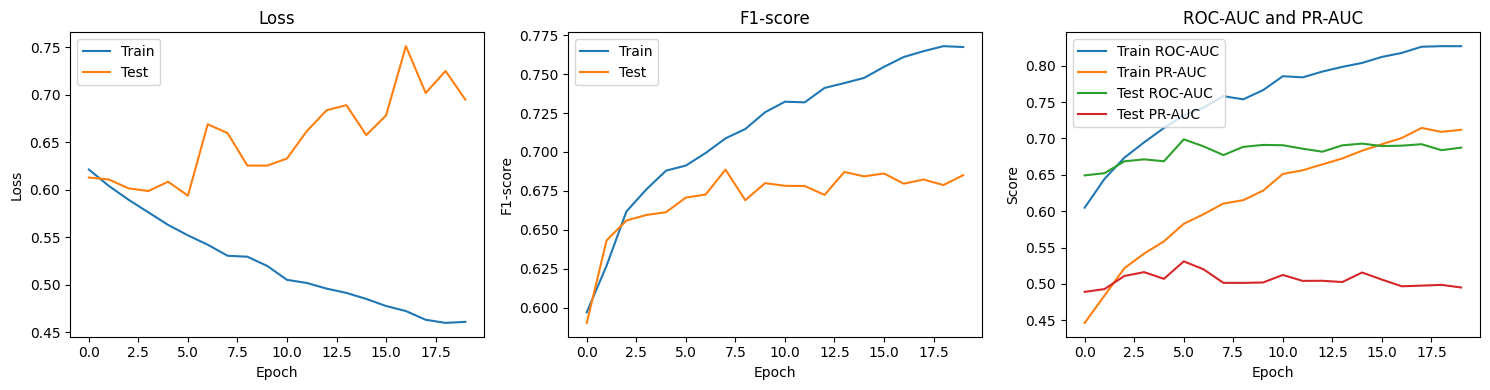

In [37]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


input_size = X.shape[1]
hidden_size = 128
output_size = 2


model = MLP(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)


epochs = 50
train_loss_history = []
train_f1_history = []
train_roc_auc_history = []
train_pr_auc_history = []
test_loss_history = []
test_f1_history = []
test_roc_auc_history = []
test_pr_auc_history = []


for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.eval()
        train_outputs = model(X_train)
        _, train_predicted = torch.max(train_outputs, 1)
        train_f1 = f1_score(y_train, train_predicted, average='weighted')
        train_loss_history.append(loss.item())
        train_f1_history.append(train_f1)
        train_roc_auc_history.append(roc_auc_score(y_train, train_outputs[:, 1]))
        train_precision, train_recall, _ = precision_recall_curve(y_train, train_outputs[:, 1])
        train_pr_auc_history.append(auc(train_recall, train_precision))
    

    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        _, test_predicted = torch.max(test_outputs, 1)
        test_loss = criterion(test_outputs, y_test)
        test_f1 = f1_score(y_test, test_predicted, average='weighted')
        test_loss_history.append(test_loss.item())
        test_f1_history.append(test_f1)
        test_roc_auc = roc_auc_score(y_test, test_outputs[:, 1])
        test_roc_auc_history.append(test_roc_auc)
        test_precision, test_recall, _ = precision_recall_curve(y_test, test_outputs[:, 1])
        test_pr_auc = auc(test_recall, test_precision)
        test_pr_auc_history.append(test_pr_auc)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Train F1-score: {train_f1:.4f}, Train ROC-AUC: {train_roc_auc_history[-1]:.4f}, Train PR-AUC: {train_pr_auc_history[-1]:.4f}, Test Loss: {test_loss.item():.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc_history[-1]:.4f}, Test PR-AUC: {test_pr_auc_history[-1]:.4f}')

Epoch [1/50], Train Loss: 0.7343, Train F1-score: 0.4291, Train ROC-AUC: 0.4909, Train PR-AUC: 0.3414, Test Loss: 0.7106, Test F1-score: 0.4361, Test ROC-AUC: 0.4924, Test PR-AUC: 0.3364
Epoch [2/50], Train Loss: 0.7114, Train F1-score: 0.5855, Train ROC-AUC: 0.5078, Train PR-AUC: 0.3526, Test Loss: 0.6926, Test F1-score: 0.5906, Test ROC-AUC: 0.5132, Test PR-AUC: 0.3441
Epoch [3/50], Train Loss: 0.6922, Train F1-score: 0.6069, Train ROC-AUC: 0.5446, Train PR-AUC: 0.3704, Test Loss: 0.6773, Test F1-score: 0.6098, Test ROC-AUC: 0.5444, Test PR-AUC: 0.3610
Epoch [4/50], Train Loss: 0.6757, Train F1-score: 0.6207, Train ROC-AUC: 0.5704, Train PR-AUC: 0.3910, Test Loss: 0.6643, Test F1-score: 0.6175, Test ROC-AUC: 0.5667, Test PR-AUC: 0.3793
Epoch [5/50], Train Loss: 0.6615, Train F1-score: 0.6296, Train ROC-AUC: 0.5834, Train PR-AUC: 0.4111, Test Loss: 0.6533, Test F1-score: 0.6244, Test ROC-AUC: 0.5792, Test PR-AUC: 0.3963
Epoch [6/50], Train Loss: 0.6492, Train F1-score: 0.6261, Train R

Epoch [48/50], Train Loss: 0.5761, Train F1-score: 0.6484, Train ROC-AUC: 0.6974, Train PR-AUC: 0.5567, Test Loss: 0.6110, Test F1-score: 0.6267, Test ROC-AUC: 0.6375, Test PR-AUC: 0.4723
Epoch [49/50], Train Loss: 0.5753, Train F1-score: 0.6496, Train ROC-AUC: 0.6987, Train PR-AUC: 0.5586, Test Loss: 0.6113, Test F1-score: 0.6282, Test ROC-AUC: 0.6374, Test PR-AUC: 0.4735
Epoch [50/50], Train Loss: 0.5745, Train F1-score: 0.6498, Train ROC-AUC: 0.7000, Train PR-AUC: 0.5602, Test Loss: 0.6116, Test F1-score: 0.6270, Test ROC-AUC: 0.6372, Test PR-AUC: 0.4738


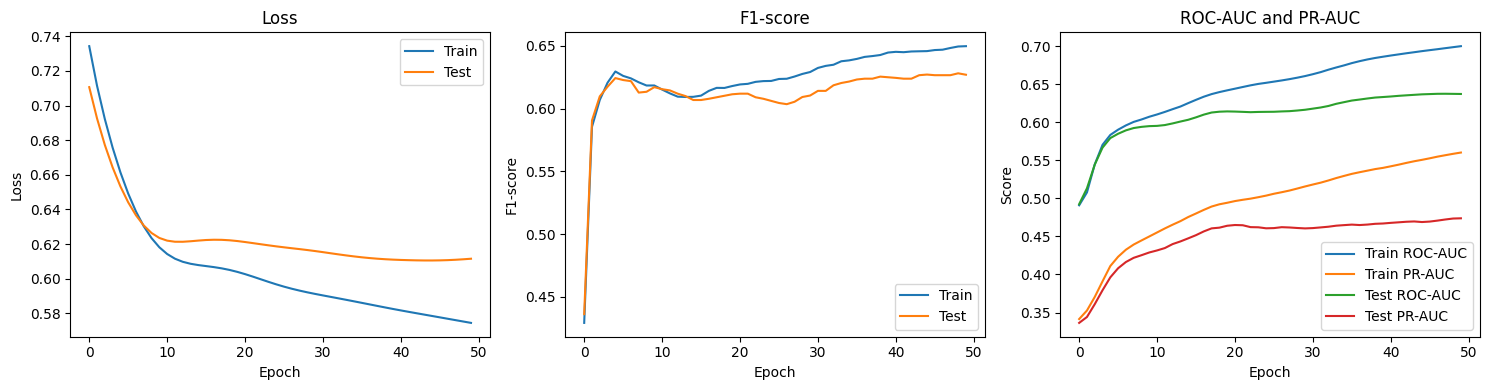

In [39]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_history, label="Train")
ax1.plot(test_loss_history, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_history, label="Train")
ax2.plot(test_f1_history, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_history, label="Train ROC-AUC")
ax3.plot(train_pr_auc_history, label="Train PR-AUC")
ax3.plot(test_roc_auc_history, label="Test ROC-AUC")
ax3.plot(test_pr_auc_history, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [40]:
import pandas as pd
import torch
array = X
df_x = pd.DataFrame(array, columns=feature_names)

In [41]:
df_x

,Histone_H3K36me3,Histone_H4K20me3,Histone_H3K36me2,Histone_H3R2me2,Histone_H2B,Histone_H4K20me1,Histone_H3K27ac,Histone_H2A.X,Histone_H3K9me3,Histone_H3K9me2,...,TFs_TP53,TFs_TP73,TFs_TRIM28,TFs_TUBG1,TFs_VRK1,TFs_WDR5,TFs_ZBTB17,TFs_ZBTB48,TFs_ZMYND11,TFs_ZNF768
0,-0.335147,-0.082965,-0.090324,-0.133067,-0.026884,-0.102712,-0.858884,-0.055363,-0.582907,-0.043181,...,-0.406394,-0.365822,-0.482183,-0.021207,-0.032672,-0.140607,-0.257609,-0.289801,-0.057472,-0.290451
1,-0.343748,1.049100,0.381367,-0.133067,-0.026884,-0.102712,-0.574909,-0.055363,-0.545187,-0.043181,...,0.038647,-0.365822,0.075445,-0.021207,-0.032672,-0.140607,-0.257609,-0.250708,-0.057472,-0.290451
2,-0.426057,-0.082965,-0.090324,-0.133067,-0.026884,-0.102712,-0.437015,-0.055363,-0.390126,-0.043181,...,-0.406394,-0.365822,-0.482183,-0.021207,-0.032672,-0.140607,-0.257609,-0.218692,-0.057472,-0.290451
3,1.952836,-0.082965,-0.090324,-0.133067,-0.026884,-0.102712,1.394502,-0.055363,1.309656,-0.043181,...,-0.406394,-0.365822,1.115490,-0.021207,-0.032672,0.111647,-0.257609,-0.256401,-0.057472,-0.290451
4,-0.426057,-0.082965,-0.090324,-0.133067,-0.026884,-0.102712,-0.868211,-0.055363,-0.559112,-0.043181,...,-0.406394,-0.365822,-0.482183,-0.021207,-0.032672,-0.140607,-0.257609,-0.289801,-0.057472,-0.290451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7267,-0.426057,-0.082965,1.030927,-0.133067,-0.026884,-0.102712,-0.073031,-0.055363,-0.582907,-0.043181,...,-0.406394,-0.365822,-0.482183,-0.021207,-0.032672,-0.140607,-0.257609,-0.187470,-0.057472,-0.290451
7268,3.078943,-0.082965,-0.090324,-0.133067,-0.026884,-0.102712,2.432070,-0.055363,2.798949,-0.043181,...,-0.068196,-0.365822,-0.054391,-0.021207,-0.032672,-0.019077,-0.257609,5.579357,-0.057472,4.043803
7269,-0.426057,-0.082965,-0.090324,-0.133067,-0.026884,-0.102712,-0.565926,-0.055363,-0.563931,-0.043181,...,-0.309211,-0.365822,-0.482183,-0.021207,-0.032672,-0.140607,-0.257609,-0.149387,-0.057472,-0.290451
7270,-0.426057,-0.082965,-0.090324,0.546070,-0.026884,-0.102712,0.218143,-0.055363,-0.317681,-0.043181,...,-0.406394,-0.365822,0.333327,-0.021207,-0.032672,-0.140607,-0.257609,-0.189329,-0.057472,-0.290451


In [42]:
array = y.numpy()
df_y = pd.DataFrame(array, columns=['target'])

In [43]:
df_y

,target
0,1
1,0
2,1
3,1
4,0
...,...
7267,0
7268,1
7269,0
7270,0


In [44]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(df_x, df_y)
importances = rf.feature_importances_
for feature, importance in zip(df_x.columns, importances):
    print(f'{feature}: {importance}')

/tmp/ipykernel_1510/162895947.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_x, df_y)


Histone_H3K36me3: 0.019707185913498085
Histone_H4K20me3: 0.0012193548072954097
Histone_H3K36me2: 0.0021198263565362576
Histone_H3R2me2: 0.0016769932227099858
Histone_H2B: 1.8655530121733197e-05
Histone_H4K20me1: 0.0006574499977446084
Histone_H3K27ac: 0.03861790042755264
Histone_H2A.X: 0.0008015149606506576
Histone_H3K9me3: 0.022166686666326197
Histone_H3K9me2: 8.665041797311732e-05
Histone_H2A.Z: 0.016168477685970108
Histone_H3K18ac: 0.014417092955428559
Histone_H3: 4.7301965294363165e-06
Histone_H4: 7.390762841322457e-05
Histone_H3K79me2: 0.008490629414813254
Histone_H3S57ph: 1.4603540828335235e-05
Histone_H2AT120ph: 5.2385710777516394e-05
Histone_H2Bub: 0.00012560091609169902
Histone_H2A.XS139ph: 0.0004334440234710483
Histone_H3K9ac: 0.023349656044685006
Histone_H3K4me2: 0.02402903610828955
Histone_H3K4me3: 0.025242100980511262
Histone_H3K27me3: 0.020312058894340367
Histone_H3K56ac: 0.02119880830984996
Histone_H3K4me1: 0.038973913618226066
Histone_H4K16ac: 0.0
Histone_H2AK120Ub: 0.00

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)x
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'PR-AUC: {pr_auc:.4f}')


/tmp/ipykernel_1510/4292731798.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


F1-score: 0.4841
ROC-AUC: 0.6299
PR-AUC: 0.5931


              feature    importance
24    Histone_H3K4me1  3.855892e-02
6     Histone_H3K27ac  3.761750e-02
64   TFs_Epitope tags  3.437141e-02
53           TFs_CTCF  2.760664e-02
21    Histone_H3K4me3  2.615848e-02
..                ...           ...
137         TFs_TUBG1  5.870137e-06
80           TFs_GLI1  2.198243e-06
107          TFs_PCNA  3.024726e-07
90           TFs_MCM5  0.000000e+00
25    Histone_H4K16ac  0.000000e+00

[144 rows x 2 columns]


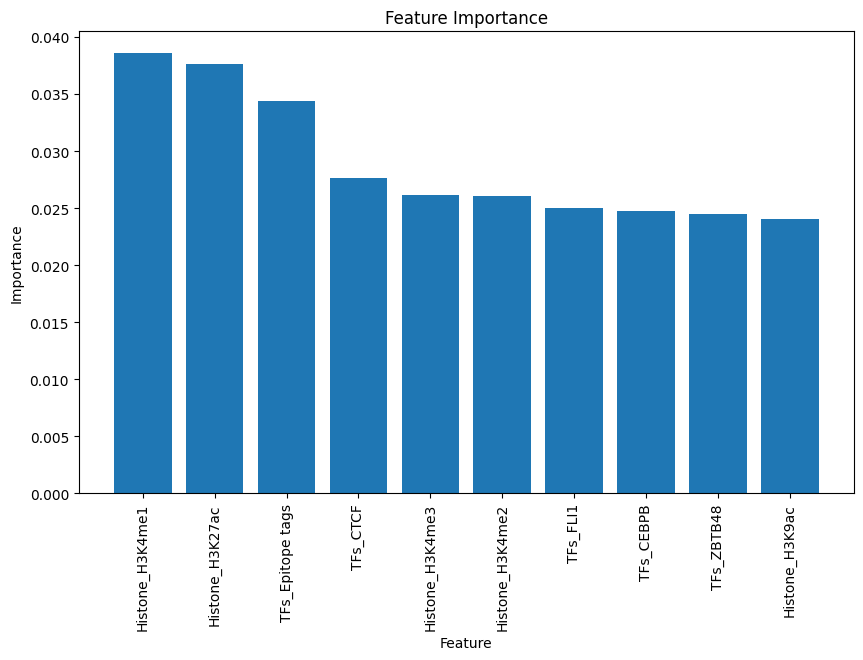

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf.feature_importances_
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


In [47]:
import catboost as cb
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
model = cb.CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1,
    depth=6, 
    random_seed=42,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
pr_roc = average_precision_score(y_test, y_pred)

print(f"F1: {f1}, AUC-ROC: {auc_roc}, PR-ROC: {pr_roc}")

0:	learn: 0.6769499	total: 51.1ms	remaining: 51s
1:	learn: 0.6642262	total: 55ms	remaining: 27.5s
2:	learn: 0.6525111	total: 58.8ms	remaining: 19.5s
3:	learn: 0.6421496	total: 62.8ms	remaining: 15.6s
4:	learn: 0.6340967	total: 66.5ms	remaining: 13.2s
5:	learn: 0.6265049	total: 70.3ms	remaining: 11.6s
6:	learn: 0.6212607	total: 73.9ms	remaining: 10.5s
7:	learn: 0.6155756	total: 77.9ms	remaining: 9.66s
8:	learn: 0.6105327	total: 81.7ms	remaining: 9s
9:	learn: 0.6075075	total: 85.9ms	remaining: 8.51s
10:	learn: 0.6036000	total: 89.4ms	remaining: 8.03s
11:	learn: 0.5986630	total: 93.6ms	remaining: 7.71s
12:	learn: 0.5951803	total: 97.2ms	remaining: 7.38s
13:	learn: 0.5921119	total: 101ms	remaining: 7.14s
14:	learn: 0.5899678	total: 105ms	remaining: 6.9s
15:	learn: 0.5881385	total: 109ms	remaining: 6.7s
16:	learn: 0.5848204	total: 113ms	remaining: 6.55s
17:	learn: 0.5821229	total: 117ms	remaining: 6.4s
18:	learn: 0.5786886	total: 122ms	remaining: 6.28s
19:	learn: 0.5772428	total: 126ms	rema

192:	learn: 0.4033560	total: 840ms	remaining: 3.51s
193:	learn: 0.4028412	total: 845ms	remaining: 3.51s
194:	learn: 0.4018058	total: 849ms	remaining: 3.5s
195:	learn: 0.4015156	total: 853ms	remaining: 3.5s
196:	learn: 0.4011818	total: 857ms	remaining: 3.49s
197:	learn: 0.4008708	total: 861ms	remaining: 3.49s
198:	learn: 0.4003493	total: 865ms	remaining: 3.48s
199:	learn: 0.4002467	total: 869ms	remaining: 3.48s
200:	learn: 0.3997306	total: 873ms	remaining: 3.47s
201:	learn: 0.3990729	total: 877ms	remaining: 3.46s
202:	learn: 0.3982981	total: 881ms	remaining: 3.46s
203:	learn: 0.3973226	total: 885ms	remaining: 3.45s
204:	learn: 0.3967433	total: 889ms	remaining: 3.45s
205:	learn: 0.3959555	total: 893ms	remaining: 3.44s
206:	learn: 0.3955257	total: 897ms	remaining: 3.44s
207:	learn: 0.3946408	total: 901ms	remaining: 3.43s
208:	learn: 0.3941342	total: 905ms	remaining: 3.42s
209:	learn: 0.3937717	total: 909ms	remaining: 3.42s
210:	learn: 0.3930510	total: 913ms	remaining: 3.41s
211:	learn: 0.

382:	learn: 0.3095607	total: 1.63s	remaining: 2.62s
383:	learn: 0.3093136	total: 1.63s	remaining: 2.62s
384:	learn: 0.3091135	total: 1.64s	remaining: 2.61s
385:	learn: 0.3086379	total: 1.64s	remaining: 2.61s
386:	learn: 0.3081747	total: 1.64s	remaining: 2.6s
387:	learn: 0.3076120	total: 1.65s	remaining: 2.6s
388:	learn: 0.3073865	total: 1.65s	remaining: 2.6s
389:	learn: 0.3069495	total: 1.66s	remaining: 2.59s
390:	learn: 0.3066392	total: 1.66s	remaining: 2.59s
391:	learn: 0.3060535	total: 1.67s	remaining: 2.58s
392:	learn: 0.3056914	total: 1.67s	remaining: 2.58s
393:	learn: 0.3055144	total: 1.67s	remaining: 2.57s
394:	learn: 0.3051505	total: 1.68s	remaining: 2.57s
395:	learn: 0.3048509	total: 1.68s	remaining: 2.56s
396:	learn: 0.3044201	total: 1.69s	remaining: 2.56s
397:	learn: 0.3040604	total: 1.69s	remaining: 2.56s
398:	learn: 0.3036363	total: 1.69s	remaining: 2.55s
399:	learn: 0.3032626	total: 1.7s	remaining: 2.55s
400:	learn: 0.3029924	total: 1.7s	remaining: 2.54s
401:	learn: 0.302

573:	learn: 0.2603657	total: 2.42s	remaining: 1.79s
574:	learn: 0.2601699	total: 2.42s	remaining: 1.79s
575:	learn: 0.2599514	total: 2.43s	remaining: 1.79s
576:	learn: 0.2598469	total: 2.43s	remaining: 1.78s
577:	learn: 0.2597421	total: 2.43s	remaining: 1.78s
578:	learn: 0.2596092	total: 2.44s	remaining: 1.77s
579:	learn: 0.2595309	total: 2.44s	remaining: 1.77s
580:	learn: 0.2592872	total: 2.45s	remaining: 1.76s
581:	learn: 0.2591306	total: 2.45s	remaining: 1.76s
582:	learn: 0.2589953	total: 2.46s	remaining: 1.76s
583:	learn: 0.2588370	total: 2.46s	remaining: 1.75s
584:	learn: 0.2587824	total: 2.46s	remaining: 1.75s
585:	learn: 0.2585511	total: 2.47s	remaining: 1.74s
586:	learn: 0.2583454	total: 2.47s	remaining: 1.74s
587:	learn: 0.2582274	total: 2.48s	remaining: 1.73s
588:	learn: 0.2581423	total: 2.48s	remaining: 1.73s
589:	learn: 0.2579928	total: 2.48s	remaining: 1.73s
590:	learn: 0.2578756	total: 2.49s	remaining: 1.72s
591:	learn: 0.2575934	total: 2.49s	remaining: 1.72s
592:	learn: 

763:	learn: 0.2331725	total: 3.2s	remaining: 989ms
764:	learn: 0.2330844	total: 3.21s	remaining: 985ms
765:	learn: 0.2329759	total: 3.21s	remaining: 981ms
766:	learn: 0.2328317	total: 3.21s	remaining: 977ms
767:	learn: 0.2327002	total: 3.22s	remaining: 972ms
768:	learn: 0.2326014	total: 3.22s	remaining: 968ms
769:	learn: 0.2324495	total: 3.23s	remaining: 964ms
770:	learn: 0.2322492	total: 3.23s	remaining: 960ms
771:	learn: 0.2321508	total: 3.23s	remaining: 955ms
772:	learn: 0.2321134	total: 3.24s	remaining: 951ms
773:	learn: 0.2319955	total: 3.24s	remaining: 947ms
774:	learn: 0.2318972	total: 3.25s	remaining: 943ms
775:	learn: 0.2317683	total: 3.25s	remaining: 939ms
776:	learn: 0.2317614	total: 3.25s	remaining: 934ms
777:	learn: 0.2316666	total: 3.26s	remaining: 930ms
778:	learn: 0.2315416	total: 3.26s	remaining: 926ms
779:	learn: 0.2313978	total: 3.27s	remaining: 922ms
780:	learn: 0.2313609	total: 3.27s	remaining: 918ms
781:	learn: 0.2311987	total: 3.28s	remaining: 913ms
782:	learn: 0

955:	learn: 0.2138765	total: 4s	remaining: 184ms
956:	learn: 0.2138189	total: 4s	remaining: 180ms
957:	learn: 0.2137091	total: 4s	remaining: 176ms
958:	learn: 0.2136529	total: 4.01s	remaining: 171ms
959:	learn: 0.2135613	total: 4.01s	remaining: 167ms
960:	learn: 0.2134296	total: 4.02s	remaining: 163ms
961:	learn: 0.2133884	total: 4.02s	remaining: 159ms
962:	learn: 0.2132601	total: 4.03s	remaining: 155ms
963:	learn: 0.2131584	total: 4.03s	remaining: 150ms
964:	learn: 0.2131020	total: 4.03s	remaining: 146ms
965:	learn: 0.2130277	total: 4.04s	remaining: 142ms
966:	learn: 0.2129296	total: 4.04s	remaining: 138ms
967:	learn: 0.2127923	total: 4.05s	remaining: 134ms
968:	learn: 0.2126730	total: 4.05s	remaining: 130ms
969:	learn: 0.2126375	total: 4.05s	remaining: 125ms
970:	learn: 0.2125758	total: 4.06s	remaining: 121ms
971:	learn: 0.2125289	total: 4.06s	remaining: 117ms
972:	learn: 0.2124773	total: 4.07s	remaining: 113ms
973:	learn: 0.2123703	total: 4.07s	remaining: 109ms
974:	learn: 0.2123052

In [48]:
feature_importances = model.feature_importances_
for feature_name, feature_importance in zip(df_x.columns, feature_importances):
    print(f"{feature_name}: {feature_importance}")

Histone_H3K36me3: 1.3963584074623863
Histone_H4K20me3: 0.22366236201106623
Histone_H3K36me2: 0.15472638832993094
Histone_H3R2me2: 0.19866571898958468
Histone_H2B: 0.0
Histone_H4K20me1: 0.10948717512186122
Histone_H3K27ac: 4.662991098239019
Histone_H2A.X: 0.048753117504767296
Histone_H3K9me3: 1.6927161627273088
Histone_H3K9me2: 0.0006231889352552833
Histone_H2A.Z: 1.4403492958808948
Histone_H3K18ac: 1.1964684875311846
Histone_H3: 0.0
Histone_H4: 0.0008601027784520121
Histone_H3K79me2: 0.6334899827540215
Histone_H3S57ph: 0.0013017116659703742
Histone_H2AT120ph: 0.0029387979624453824
Histone_H2Bub: 0.009142020140431601
Histone_H2A.XS139ph: 0.006904495102049439
Histone_H3K9ac: 2.6955975144995787
Histone_H3K4me2: 2.4486429033070465
Histone_H3K4me3: 3.738665003473013
Histone_H3K27me3: 2.26236383046197
Histone_H3K56ac: 1.3432288815323685
Histone_H3K4me1: 4.3831918533229715
Histone_H4K16ac: 0.0027884189335629713
Histone_H2AK120Ub: 0.0
Histone_H1.4: 1.6251382300743213
Histone_H2Aub: 0.000905993

               feature  importance
6      Histone_H3K27ac    4.662991
24     Histone_H3K4me1    4.383192
64    TFs_Epitope tags    3.841300
44           TFs_CEBPB    3.774893
21     Histone_H3K4me3    3.738665
..                 ...         ...
36            TFs_BMI1    0.000000
31   Histone_H2AK119Ub    0.000000
107           TFs_PCNA    0.000000
26   Histone_H2AK120Ub    0.000000
72          TFs_FANCD2    0.000000

[144 rows x 2 columns]


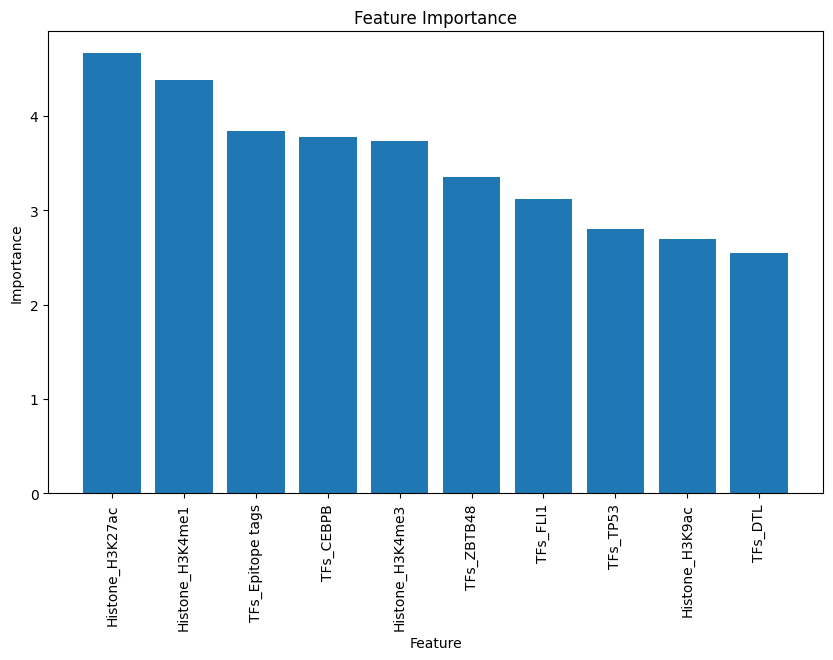

In [49]:

importances = feature_importances
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
